In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
import ipywidgets as widgets
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output
from scipy.linalg import expm
import time
#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))


def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive_Fermi(mu,Gamma=Gamma,Lambda=Lambda):
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    beta=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
    plt.figure(figsize=(10,7))
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.ylabel("Energy")
    plt.show()
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)

def Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous

def Toeplitz_matrix(Fourier_plus,L):
    First_column=np.roll(Fourier_plus,-1)[::-1][:L]
    First_row = Fourier_plus[:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    First_column=Fourier_minous[::-1][:L]
    Last_row=np.roll(Fourier_minous,L-1)[::-1][:L]
    return hankel(First_column,Last_row)


def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))/N_size

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L,N_size=N_size):
    return (Toeplitz_matrix(F_plus,L)+Hankel_matrix(F_minous,L))/N_size

In [2]:
interactive_plot = interactive(plot_interactive_Fermi,
                               mu=widgets.FloatSlider(min=0, max=3, step=0.1, value=0,continuous_update=False)
                               ,Gamma=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5,continuous_update=False)
                               ,Lambda=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5,continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='mu', max=3.0), FloatSlider(…

# Test the values of singular values ( I still do not understand Why it is not between $-1$ and $1$ 

In [3]:
tests=50
S_all=[]
L_max=71
for L in range(7,L_max,2):
    print("L=",L)
    S_aux=[]
    for i in range(tests):
        F_plus,F_minous=Get_Bands_Matrix(N_size=N_size,Ground=False)
        New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
        S=np.linalg.svd(New_cov_matrix,full_matrices=False,compute_uv=False)
        S_aux.append(S)
    #print(np.array(S_aux))
    #print(np.mean(np.array(S_aux),axis=0))
    S_all.append(np.mean(S_aux,axis=0))

L= 7
L= 9
L= 11
L= 13
L= 15
L= 17
L= 19
L= 21
L= 23
L= 25
L= 27
L= 29
L= 31
L= 33
L= 35
L= 37
L= 39
L= 41
L= 43
L= 45
L= 47
L= 49
L= 51
L= 53
L= 55
L= 57
L= 59
L= 61
L= 63
L= 65
L= 67
L= 69


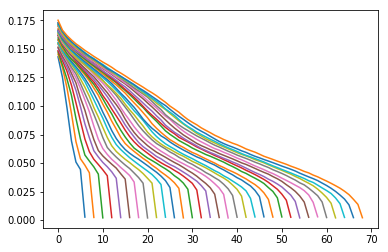

In [5]:
for i in range(len(S_all)):
    plt.plot(S_all[i])
plt.show()

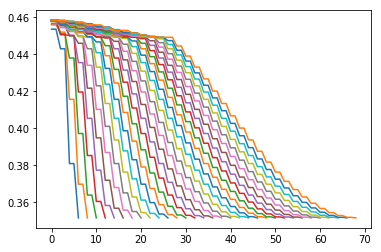

In [30]:
for L in range(7,71,2):
    n=np.arange(-(L-1)/2,(L-1)/2+ 1)
    f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
    plt.plot(sorted(f,reverse=True))
plt.show()

In [14]:
with open("Singular_values/Singular_values.txt","w") as f:
    for i in range(len(S_all)):
        for j in range(len(S_all[i])):   
            if j == len(S_all[i]) -1 :
                f.write(str(S_all[i][j])+"\n")
            else:
                f.write(str(S_all[i][j])+",")
    f.close()

In [20]:
with open("Singular_values/Singular_values.txt","r") as f:
    Singular_values_read=[]
    for i in f.readlines():
        Singular_values_read.append((np.array(i[:-1].split(","),dtype=np.float)))

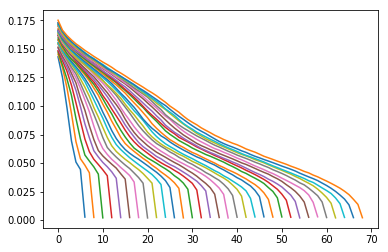

In [21]:
for i in range(len(Singular_values_read)):
    plt.plot(Singular_values_read[i])
plt.show()

# It is working now i can read and write more of them

In [22]:
tests=50
S_all_2=[]
L_max=251
for L in range(73,L_max,5):
    print("L=",L)
    S_aux=[]
    for i in range(tests):
        F_plus,F_minous=Get_Bands_Matrix(N_size=N_size,Ground=False)
        New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
        S=np.linalg.svd(New_cov_matrix,full_matrices=False,compute_uv=False)
        S_aux.append(S)
    #print(np.array(S_aux))
    #print(np.mean(np.array(S_aux),axis=0))
    S_all_2.append(np.mean(S_aux,axis=0))

L= 71


In [23]:
with open("Singular_values/Singular_values.txt","a") as f:
    for i in range(len(S_all_2)):
        for j in range(len(S_all_2[i])):   
            if j == len(S_all_2[i]) -1 :
                f.write(str(S_all_2[i][j])+"\n")
            else:
                f.write(str(S_all_2[i][j])+",")
    f.close()

In [24]:
with open("Singular_values/Singular_values.txt","r") as f:
    Singular_values_read=[]
    for i in f.readlines():
        Singular_values_read.append((np.array(i[:-1].split(","),dtype=np.float)))

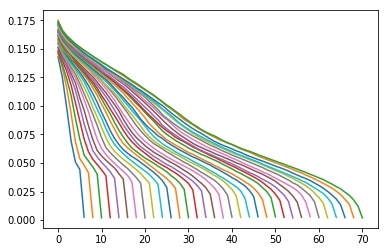

In [26]:
for i in range(len(Singular_values_read)):
    plt.plot(Singular_values_read[i])
plt.show()

In [ ]:

L=N_size//100 +1
beta=0.40824
rho=np.zeros((L,L),dtype=np.complex)
#F_plus_total=np.zeros((tests,N_size),dtype=np.complex)
#F_minous_total=np.zeros((tests,N_size),dtype=np.complex)
singular_values=[]
for i in range(tests):
    F_plus,F_minous=Get_Bands_Matrix(N_size=N_size,Ground=False)
    New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
    O_1,S,O_2=np.linalg.svd(New_cov_matrix)
    singular_values.append(S)
    S=-S+0.5
    x=(np.log((1-S)/(S)))
    rho+=expm((O_1@np.diag(x)@O_2))/tests